
# Questions Generation and Answering

This is the first notebook, where I **preprocess text**, **extract key phrases** and **generate questions** using the T5 model.

Question answering using AllenNLP and HayStack, using T5's questions, are in the next 2 notebooks.


**Table of Contents**
1. Business Understanding
2. Installations
3. Imports
4. Load and Preprocess Text
5. Key Phrase Extraction
6. Question Generation using T5 Model
7. Generate DataFrame out of questions, answers, and phrases


# 1. Business Understanding

Question Generation (QG) aims to generate natural language questions based on given text, where the generated questions need to be able to be answered by the contents.

It can be used in many ways such as generating questionnaires depending on the answers, as well as chatbots.

The goal here is to pass on to the models a piece of text, and have it generate the questions and answers.

# 2. Installations

In [1]:
# Text preprocessing 
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 3.9 MB/s eta 0:00:00


In [2]:
# Key phrase extraction
!pip install git+https://github.com/boudinfl/pke.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-apojqp3_
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-apojqp3_
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 11.3 MB/s eta 0:00:00
  Created wheel for pke: filename=pke-2.0.0-py3-none-any.whl size=6160676 sha256=6094c490c05679b3dd5ad122215e954d10a2675baff9e5d46f04441a404e0361
  Stored in directory: /tmp/pip-ephem-wheel-cache-22cwjf4n/wheels/d5/46/97/85535b5b449f70b6a3c8d1138ce8587345876891e25bfe7954
Successfully built pke


In [3]:
# Sentence mapping
!pip install flashtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9308 sha256=e93e9786e5296ad0bf16299d2cec6d7b09763b170713bc54ae55fee1a22fb28a
  Stored in directory: /root/.cache/pip/wheels/65/3c/c7/44672c5062c16d05760b1eaddbf611d2f6a4b715c6d6777418
Successfully built flashtext


In [4]:
# Question eneration - T5
!pip install transformers
!python -m nltk.downloader punkt
!git clone https://github.com/patil-suraj/question_generation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Cloning into 'question_generation'...
remote: Enumerating objects: 268, done.
remote: Total 268 (delta 0), reused 0 (delta 0), pack-reused 268
Receiving objects: 100% (268/268), 299.04 KiB | 7.29 MiB/s, done.
Resolving deltas: 100% (140/140), done.


# 3. Imports

In [19]:
# Text preprocessing
import re
from string import digits
import contractions
# Key phrase extraction
import pke
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Sentence mapping
from nltk.tokenize import sent_tokenize
from flashtext import KeywordProcessor
import nltk
nltk.download('punkt')
# Question eneration - T5
%cd question_generation
from pipelines import pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[Errno 2] No such file or directory: 'question_generation'
/content/question_generation


# 4. Load and preprocess text

From what I found in the data by looking at it:

**Things to deal with:**
- Arabic words ✅ 
- Emails ✅
- Random numbers ✅
- Citations, eg. [20] ✅

**Other things that can be done:**
- Lowercase ✅
- Expand contractions ✅
- Replace c++ with cpp and c# to c sharp ✅
- Remove hyphens, colons and semi-colons - ✅
- Remove full stops .
- Remove slashes \ / \\ // ✅
- Remove extra spaces ✅

### ✅ Preprocessing pipeline

In [6]:
def preprocess(file_name):
    ''' 
        Returns preprocessed txt file.
        
        input : file name (str)
        returns : preprocessed file (str)
    '''
    with open(file_name, encoding="utf-8", errors='ignore') as f:
        data = f.read()
    
    # Convert to lower
    data = data.lower()
    # Remove Arabic words
    data = re.sub('[\u0600-\u06ff]+', '', data)
    # Remove E-mails
    data = re.sub("\S*@\S*\s?", '', data)
    # Remove numbers
    remove_digits = str.maketrans('', '', digits)
    data = data.translate(remove_digits)
    # Replace c++ with cpp and c# to c sharp
    data = data.replace("c++", "cpp" )
    data = data.replace("c#", "c sharp" )
    # Remove punctuation
    punct = '!"$%&\()*-/:;<=>?@[\\]^_`{|}~'
    data = data.translate(str.maketrans('', '', punct))
    # Expand contractions
    data = contractions.fix(data)
    # Cleaning up
    data = re.sub(r' ,+', " ", data)
    data = re.sub(r' -+', " ", data)
    data = re.sub(r'\.+', ".", data)
    data = re.sub(r' . +', " ", data)
    data = re.sub(r' ,.+', ",", data)
    data = re.sub(r' .,+', ",", data)
    # Remove extra spaces
    data = re.sub(' +', ' ', data)
    
    return data

In [18]:
data = preprocess('../deeplearning.txt')

In [20]:
str(data)

'deep learning also known as deep structured learning is part of broader family of machine learning methods based on artificial neural networks with representation learning. learning can be supervised, semisupervised or unsupervised.\n\ndeeplearning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks, convolutional neural networks and transformers have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, climate science, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance.\n\nartificial neural networks anns were inspired by information processing and distributed communication nodes in biological systems. anns have various differences from biological brains. specifically, artificial neural networks tend to be

# 5. Key phrase Extraction

## Algorithms:

**Unsupervised:**
- **Statistical model:**
    - FirstPhrases ✅
    - TfIdf
    - KPMiner ✅
    - YAKE ✅
    
- **Graph-based model:**
    - TextRank ✅
    - SingleRank
    - TopicRank ✅ 
    - TopicalPageRank 
    - PositionRank 
    - MultipartiteRank
    
**Supervised:**
- **Feature-based models**
    - Kea ✅

In [21]:
def key_extract(extractor):   
    ''' 
        Returns top 10 key phrases that are extracted from text.
        
        input : pk extractor (initialize keyphrase extraction model)
        returns : list of top 10 key phrases and scores (list)
    '''
    # load the content of the document, here document is expected to be a simple 
    # test string and preprocessing is carried out using spacy
    extractor.load_document(input=data, language='en')
    # keyphrase candidate selection, in the case of TopicRank: sequences of nouns
    # and adjectives (i.e. `(Noun|Adj)*`)
    extractor.candidate_selection()
    # candidate weighting, in the case of TopicRank: using a random walk algorithm
    extractor.candidate_weighting()
    # N-best selection, keyphrases contains the 10 highest scored candidates as
    # (keyphrase, score) tuples
    keyphrases = extractor.get_n_best(n=10)
    
    return keyphrases

## 5.1. YAKE
> YAKE (Yet Another Keyword Extractor) is a light weight unsupervised keyword extraction approach. It heavily relies on statistical text features which are selected and computed from a single document.

> The algorithm for YAKE contains 5 steps:
> - Text Pre-processing and candidate term identification
>- Feature Extraction
>- Computing Term Score
>- N-gram generation and computing candidate keyword score
> - Data deduplication and Ranking

In [22]:
keyphrases_yake = key_extract(pke.unsupervised.YAKE())
keyphrases_yake

[('deep learning', 0.006934718411844298),
 ('deep', 0.009240676475484579),
 ('learning', 0.010640762696687553),
 ('neural networks', 0.013388593935782303),
 ('networks', 0.022408439656446323),
 ('neural', 0.02302068131084594),
 ('deep neural networks', 0.026519496520377984),
 ('artificial neural networks', 0.02653588875770256),
 ('deep neural', 0.030894910684791936),
 ('layers', 0.039445752356224016)]

## 5.2. FirstPhrases

In [23]:
keyphrases_frstph = key_extract(pke.unsupervised.FirstPhrases())
keyphrases_frstph

[('deep learning', 0),
 ('deep structured learning', -5),
 ('part', -9),
 ('broader family', -11),
 ('machine learning methods', -14),
 ('artificial neural networks', -19),
 ('representation learning', -23),
 ('learning', -26),
 ('semisupervised', -31),
 ('deeplearning architectures such', -36)]

## 5.3. KPMiner
> Uses statistical and linguistic methods to identify and extract important phrases from a piece of text. Here are some key features of KPMiner:

> - **Statistical and linguistic analysis**: KPMiner uses a combination of statistical and linguistic features to identify candidate phrases in a text. These features include word frequency, part-of-speech tags, and semantic relationships between words.
- **Ranking and selection**: The algorithm uses a set of heuristics to rank the candidate phrases and select the most important ones. These heuristics take into account the frequency, position, and length of the phrases, as well as their relevance to the overall content of the text.
- **Multi-word phrase extraction**: One of the strengths of KPMiner is its ability to extract important phrases even when they are not single words, but rather multi-word expressions or phrases. This can be particularly useful in domains where key information is often expressed in phrases rather than single words.

In [24]:
keyphrases_kp = key_extract(pke.unsupervised.KPMiner())
keyphrases_kp

[('deep learning', 276.03028424656077),
 ('neural networks', 246.97446485218597),
 ('deep', 133.01302380386983),
 ('neural', 78.11409201799424),
 ('artificial neural', 72.63954848593706),
 ('artificial neural networks', 72.63954848593706),
 ('deep neural', 72.63954848593706),
 ('deep neural networks', 72.63954848593706),
 ('layers', 62.87558189280659),
 ('machine learning', 58.111638788749644)]

## 5.4. TextRank

>It is based on a graph where each node is a word, and edges represent relationships between words which are formed by defining the co-occurrence of words within a moving window of a predetermined size.
>
>It first Tokenizes and annotates text with Part of Speech (PoS). It only considers single words. However, no n-grams are used, multi-words are reconstructed later. An edge is created if lexical units co-occur within a window of N-words to obtain an unweighted undirected graph. Then it runs the text rank algorithm to rank the words. The most important lexical words are selected and then adjacent keywords are folded into a multi-word keyword.

In [25]:
keyphrases_text = key_extract(pke.unsupervised.TextRank())
keyphrases_text

[('modern deep learning models', 0.05986257923070822),
 ('deep learning architectures', 0.05357638924649095),
 ('deep learning process', 0.05224664502714064),
 ('deep learning methods', 0.05042064531404186),
 ('deep structured learning', 0.04949011368043078),
 ('deep learning systems', 0.048138848686537866),
 ('deep reinforcement learning', 0.04754737425899486),
 ('deep generative models such', 0.04622814692440721),
 ('term deep learning', 0.0460978591110826),
 ('first representational layer', 0.04462226256240238)]

## 5.5. TopicRank
> TopicRank is an unsupervised graph-based ranking model to keyphrase extraction that is often used as a baseline by the research community. TopicRank relies on a graph-based topical representation of the input document, and uses a random walk algorithm derived from PageRank to estimate the importance of each topic (node). The most representative phrase candidates belonging to the highest-scored topics are then selected as keyphrases.

In [26]:
keyphrases_topic = key_extract(pke.unsupervised.TopicRank())
keyphrases_topic

[('artificial neural networks', 0.0732762670458468),
 ('deep learning', 0.0604903758873296),
 ('multiple layers', 0.04382453465215226),
 ('cap', 0.026035943232329523),
 ('universal classifier', 0.025066426485833876),
 ('raw input', 0.022361926067525184),
 ('machine learning methods', 0.01658825435491089),
 ('interpretations', 0.01576386220695604),
 ('data', 0.015462862356248405),
 ('representation learning', 0.013984722479904892)]

## 5.6. Kea 
> A rule-based algorithm that uses linguistic and statistical methods to identify and extract key phrases from a document. It identifies noun phrases and adjectives that are frequently used in the text and ranks them based on their frequency and position in the text.

In [27]:
keyphrases_kea = key_extract(pke.supervised.Kea())
keyphrases_kea

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.20.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[('deep learning', 0.050002973210251184),
 ('deep', 0.047242368872558095),
 ('neural networks', 0.019810443899411497),
 ('neural', 0.018344289904235332),
 ('layers', 0.012679939510301816),
 ('learning', 0.010174019715554723),
 ('cap', 0.009056966066574496),
 ('artificial neural', 0.008842914284022913),
 ('artificial neural networks', 0.008842914284022913),
 ('deep neural', 0.008719621549514691)]

## Key phrases comparison

In [28]:
# Put all key phrases from all models into a list
all_keyphrases = keyphrases_kea + keyphrases_topic + keyphrases_text + keyphrases_kp + keyphrases_frstph + keyphrases_yake

In [29]:
# Create a `key phrase : # times repeated` dictionary
keywords = {}
for i, word in enumerate(all_keyphrases):
    if word[0] in keywords:
        keywords[word[0]] += 1
    else:
        keywords[word[0]] = 1

keywords_dict = dict(sorted(keywords.items(), key=lambda item: item[1], reverse=True))

## Plot

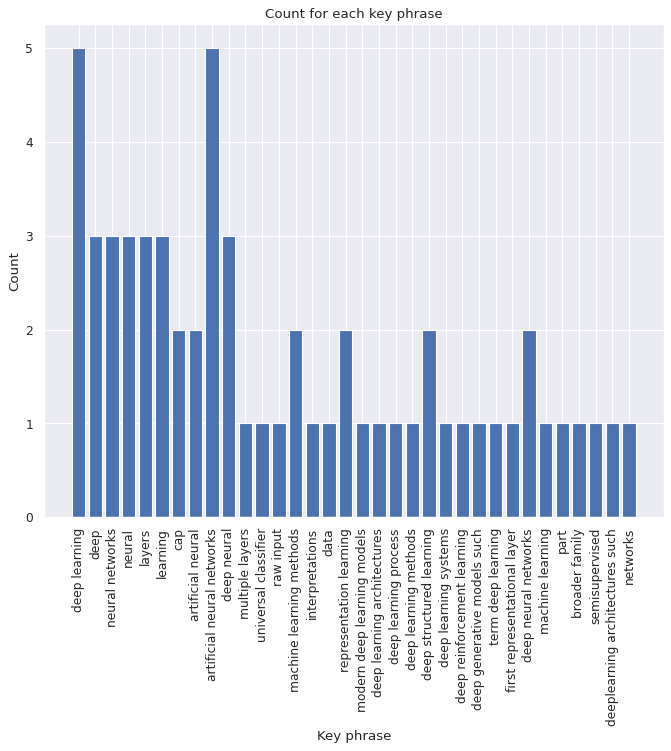

In [30]:
sns.set()
plt.figure(figsize=(10, 8), dpi=80)

plt.bar(range(len(keywords)), list(keywords.values()), align='center')
plt.xticks(range(len(keywords)), list(keywords.keys()), rotation = 90)
plt.xlabel('Key phrase')
plt.ylabel('Count')
plt.title('Count for each key phrase')
plt.show()

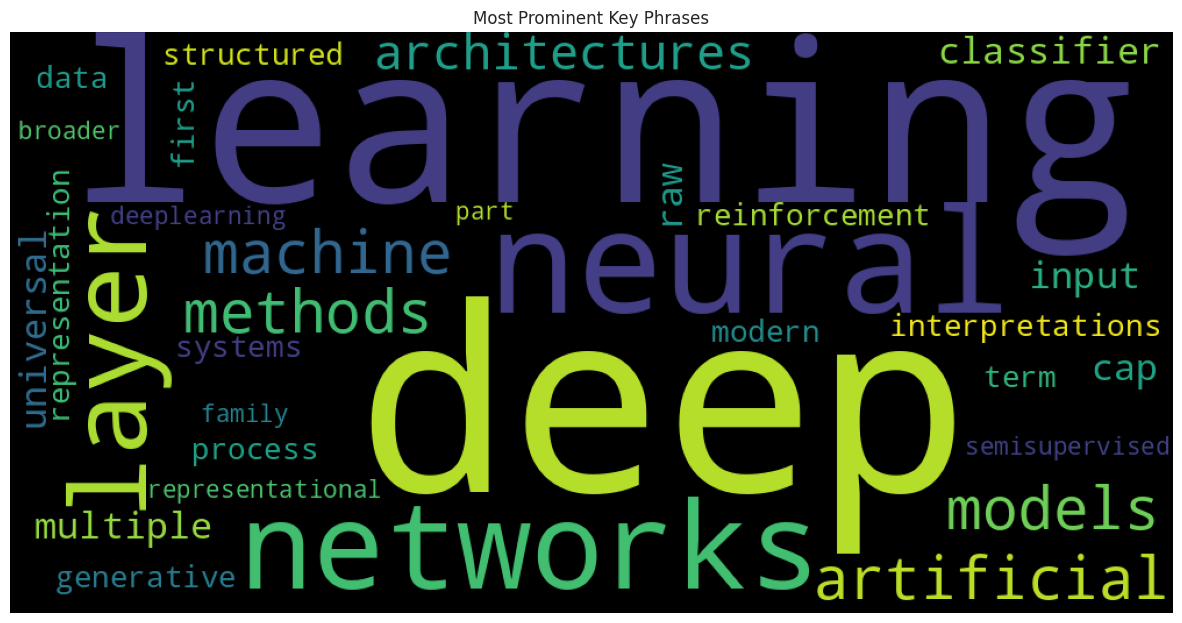

In [31]:
# Word Cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(keywords))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Prominent Key Phrases")
plt.axis("off")
plt.show()

## Sentence Mapping
> 

> Map key phrases extracted to sentences in the input text

`{'keyphrase' : [sentence1, sentence2], ...}`

In [32]:
def tokenize_sentences(text):
    sentences = [sent_tokenize(text)]
    sentences = [y for x in sentences for y in x]
    # Remove any short sentences less than 20 letters.
    sentences = [sentence.strip() for sentence in sentences if len(sentence) > 20]
    return sentences

def get_sentences_for_keyword(keywords, sentences):
    keyword_processor = KeywordProcessor()
    keyword_sentences = {}
    for word in keywords:
        keyword_sentences[word] = []
        keyword_processor.add_keyword(word)
    for sentence in sentences:
        keywords_found = keyword_processor.extract_keywords(sentence)
        for key in keywords_found:
            keyword_sentences[key].append(sentence)

    for key in keyword_sentences.keys():
        values = keyword_sentences[key]
        values = sorted(values, key=len, reverse=True)
        keyword_sentences[key] = values
    return keyword_sentences

sentences = tokenize_sentences(data)
keyword_sentence_mapping = get_sentences_for_keyword(list(keywords_dict.keys()), sentences)

### Join all sentences in a list and remove duplicates

In [33]:
keyphrases = list(keywords_dict.keys())
phraselist = []
for i in keyphrases:
  phraselist.extend(keyword_sentence_mapping[i])
phraselist = list(dict.fromkeys(phraselist))
for i, phrase in enumerate(phraselist):
  print(f'{i}:   {phrase}')

0:   no universally agreedupon threshold of depth divides shallow learning from deep learning, but most researchers agree that deep learning involves cap depth higher than cap of depth has been shown to be universal approximator in the sense that it can emulate any function.
1:   deep learning is modern variation which is concerned with an unbounded number of layers of bounded size, which permits practical application and optimized implementation, while retaining theoretical universality under mild conditions.
2:   in deep learning the layers are also permitted to be heterogeneous and to deviate widely from biologically informed connectionist models, for the sake of efficiency, trainability and understandability, hence the structured part.
3:   deep learning also known as deep structured learning is part of broader family of machine learning methods based on artificial neural networks with representation learning.
4:   definition
deep learning is class of machine learning algorithms th

# 6. Question Generation using t5 model

In [ ]:
nlp = pipeline("question-generation", model="valhalla/t5-base-qg-hl")

In [ ]:
questionlist = []
answerlist = []
dupphrases = []
for i, phrase in enumerate(phraselist):
  try:
    print(f'From phrase {i}:')
    ques_ans_gen = nlp(phrase)
    for quesans_dict in ques_ans_gen:
      print(f'Question: {quesans_dict["question"]}')
      questionlist.append(quesans_dict["question"])
      print(f'Answer: {quesans_dict["answer"]}')
      answerlist.append(quesans_dict["answer"])

      dupphrases.append(phrase)
      print()
  except:
    print(f'From phrase {i}: Error... Model cannot generate question. \n\n')

From phrase 0:


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:1500: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beam_id = beam_token_id // vocab_size


Question: What is the term for a cap depth higher than cap of depth?
Answer: universal approximator

Question: Is there a universally agreed upon threshold of depth that divides shallow learning from deep learning?
Answer: no

From phrase 1:
Question: What is modern variation concerned with an unbounded number of layers of bounded size?
Answer: deep learning

Question: Under what conditions does deep learning retain theoretical universality?
Answer: mild

From phrase 2:
Question: What are layers allowed to deviate widely from biologically informed connectionist models for the sake of efficiency, trainability and understandability?
Answer: the structured part

From phrase 3:
Question: What is another name for deep learning?
Answer: deep structured learning

Question: What is deep structured learning based on?
Answer: artificial neural networks

From phrase 4:
Question: What is a class of machine learning algorithms that uses multiple layers to extract higherlevel features from raw input

# 7. Generate DataFrame out of questions, answers, and phrases

In [ ]:
print(questionlist)
print(answerlist)
print(dupphrases)

['What is the term for a cap depth higher than cap of depth?', 'Is there a universally agreed upon threshold of depth that divides shallow learning from deep learning?', 'What is modern variation concerned with an unbounded number of layers of bounded size?', 'Under what conditions does deep learning retain theoretical universality?', 'What are layers allowed to deviate widely from biologically informed connectionist models for the sake of efficiency, trainability and understandability?', 'What is another name for deep learning?', 'What is deep structured learning based on?', 'What is a class of machine learning algorithms that uses multiple layers to extract higherlevel features from raw input?', 'In what type of learning does each level learn to transform its input data into slightly more abstract and composite representation?', 'What does each level learn to transform its input data into?', 'What helps to disentangle abstractions and pick out features that improve performance?', 'Wh

In [ ]:
import pandas as pd
t5dict = {'phrase': dupphrases, 't5_question': questionlist, 't5_answer': answerlist} 
    
df = pd.DataFrame(t5dict)

In [ ]:
df.head()

,phrase,t5_question,t5_answer
0,no universally agreedupon threshold of depth d...,What is the term for a cap depth higher than c...,universal approximator
1,no universally agreedupon threshold of depth d...,Is there a universally agreed upon threshold o...,no
2,deep learning is modern variation which is con...,What is modern variation concerned with an unb...,deep learning
3,deep learning is modern variation which is con...,Under what conditions does deep learning retai...,mild
4,in deep learning the layers are also permitted...,What are layers allowed to deviate widely from...,the structured part


# Save DataFrame as CSV to Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path = '/content/drive/My Drive/DeepLearning.csv'

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   df.to_csv(f, index = False)